<a href="https://colab.research.google.com/github/IshaPatro/Pricing-Barrier-Options-Using-Monte-Carlo-Simulation/blob/main/Pricing_Barrier_Options_Using_Monte_Carlo_Simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pricing Barrier Options Using Monte Carlo Simulation

##Goal

The objective of this project is to price a European Down-and-Out Barrier Call option using Monte Carlo simulation. We simulate many possible future paths of the underlying asset under the risk-neutral measure and estimate the option price by averaging discounted payoffs.

## Barrier Options
*   Exotic options whose payoff depend on whether the underlying asset hits a specifier barrier level
*   Path dependent: requires continuous of the underlying asset's price over time
*   Widely traded in FX, equities, commodities.


### Barrier Option Types
Based on how the barrier affects the contract validity
1.   **Knock-Out Options**
      *   *Mechanism:* The option does not exist if the asset price touches the barrier.
      * *Outcome:* If the barrier is breached, the option instantly becomes worthless (ceases to exist).
      *   *Use Case:* Ideal for traders who believe a trend will continue but won't reverse sharply.


2.   **Knock-In Options**
      * *Mechanism:* The option does not exist until the asset price touches the barrier.
      * *Outcome:* If the barrier is breached, the option "wakes up" and becomes a standard vanilla option.
      * *Use Case:* Ideal for traders waiting for a breakout confirmation before entering a position.




### Directional Variants
| **Type**        | **Description**  | **Market View (Call)**  | **Market View (Put)** |
|-----------------|---------------------------------------------------------------------|---------------------------------------------------------------------|---------------------------------------------------------------------|
| **Up-and-Out**  | Option dies if price rises to barrier **H (H > S₀)**.                     | Bullish but capped. Expect price to rise, but not too much.                              | Mildly bearish. Expect slight decline; if price rises too much, bearish view is invalid. |
| **Down-and-Out**| Option dies if price falls to barrier **H (H < S₀)**.                     | Bullish and confident price won't crash.                                                  | Bearish but expect only a small decline, not a deep drop.                                |
| **Up-and-In**   | Option activates only if price rises to barrier **H (H > S₀)**.           | Bullish breakout. Want the call only if resistance is broken.                            | Expect price to break resistance then reverse downward (reversion trade).                |
| **Down-and-In** | Option activates only if price falls to barrier **H (H < S₀)**.           | Buy-the-dip activation. Want the call only if the price drops first.                     | Bearish breakout. Want the put only if support breaks and downtrend accelerates.         |

## Modeling Assumptions

---

### **1. Dynamics of the Underlying**

The asset price \( S_t \) follows **Geometric Brownian Motion (GBM)** under the risk-neutral measure:

$$
dS_t = r S_t\, dt + \sigma S_t\, dW_t
$$

This implies:

- Prices remain positive (lognormal distribution)  
- Drift equals the risk-free rate \( r \) to avoid arbitrage  

---

### **2. Constant Parameters**

All model inputs remain constant throughout the option’s life:

- $$
\displaystyle
S_0 = 620.0
\quad\text{: initial (spot) price of the underlying at } t = 0.
$$

- $$
\displaystyle
\sigma = 0.25
\quad\text{: annualized volatility (25% per year).}
$$

- $$
\displaystyle
r = 0.03
\quad\text{: continuously compounded risk - free rate (3% per year).}
$$

- $$
\displaystyle
T = 0.5
\quad\text{: time to maturity expressed in years (0.5 = 6 months).}
$$

- $$
\displaystyle
K = 630
\quad\text{: strike price (2% above the initial spot).}
$$



---

### **3. Discretized Barrier Monitoring**

The barrier is checked at every simulated time step:

- If the price ever falls **at or below** the barrier \( B \),  
the option becomes **worthless** (“knocks out”).  
- If the barrier is never breached, payoff depends on the terminal price.

---

### **4. European Exercise**

The option may be exercised **only at maturity**, and only if the barrier has **not** been breached at any point during \([0, T]\).

The payoff is therefore:

$$
\text{Payoff} =
\begin{cases}
\max(S_T - K, 0), & \text{if } S_t > B \ \text{for all} \ t \in [0, T], \\
0, & \text{otherwise}.
\end{cases}
$$

---


In [ ]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

In [ ]:
S0 = 620.0
sigma = 0.25
r = 0.03
T = 0.5
K = 630

option_type="call"
knock="out"
barrier_type="down"

if barrier_type.lower() == "down":
    B = S0 * 0.85
else:
    B = S0 * 1.15

## ⏱️ Time Discretization

To simulate the option over its lifetime, we divide the maturity $T$ into small time steps:

- **$\Delta t = \dfrac{1}{252}$**  
  Daily time step (assuming 252 trading days per year).

- **$M = \dfrac{T}{\Delta t}$**  
  Total number of simulation steps required to reach maturity.

- **`time_grid = np.linspace(0, T, M + 1)`**  
  A sequence of time points from $0$ to $T$, used to advance the GBM process and monitor the barrier at each step.

- **`N`**  
  Number of Monte Carlo paths to simulate; larger $N$ increases accuracy.


In [ ]:
dt = 1/252
M = int(T / dt)
time_grid = np.linspace(0, T, M + 1)
N = 1000
print(f"Number of time steps: {M}")

Number of time steps: 126


## Monte Carlo Pricing

This function prices a barrier option using Monte Carlo simulation under Geometric Brownian Motion (GBM). It supports call/put options, up/down barriers, and knock-in/knock-out features.

---

### 1. Simulating GBM Price Paths

The asset is assumed to follow GBM under the risk-neutral measure.  
Each time step evolves according to:

$$
S_{t+\Delta t} = S_t \exp\!\left((r - \tfrac{1}{2}\sigma^2)\Delta t + \sigma\sqrt{\Delta t}\,Z\right),
\quad Z \sim N(0,1)
$$

A matrix \(S\) of shape \((M+1, N)\) stores all simulated paths:
- rows represent time steps  
- columns represent independent sample paths  

---

### 2. Detecting Barrier Hits

Barrier monitoring is evaluated over the entire simulated path:

- **Down barrier:** a path hits the barrier if  
  $$
  S_t \le B \quad
  $$
- **Up barrier:** a path hits the barrier if  
  $$
  S_t \ge B \quad
  $$

---

### 3. Computing Vanilla Payoff at Maturity

The vanilla option payoff (before applying barrier conditions) is computed at maturity:

- Call option payoff:  
  $$
  \max(S_T - K,\, 0)
  $$

- Put option payoff:  
  $$
  \max(K - S_T,\, 0)
  $$

These raw payoff values are then adjusted based on the knock-in or knock-out rule.

---

### 4. Applying Knock-In / Knock-Out Logic

- **Knock-Out Option:**  
  Payoff is zero if the barrier was hit.

  - if hit → payoff = 0  
  - else   → payoff = vanilla payoff

- **Knock-In Option:**  
  Payoff exists only if the barrier was hit.

  - if hit → payoff = vanilla payoff  
  - else   → payoff = 0  

---

### 5. Discounting and Averaging

The final barrier option price is the discounted expected payoff:

$$
\text{Price} = e^{-rT} \cdot \mathbb{E}[\text{Payoff}]
$$

---

### Returned Values

The function returns five elements:

1. **discounted option price**  
2. **path-level payoffs**  
3. **terminal prices**
4. **indicator array of barrier hits**  
5. **full matrix of simulated paths**


In [ ]:
def barrier_option_mc(S0, K, B, r, sigma, T, M, N, dt,
                      option_type="call", knock="out", barrier_type="down"):

    nudt = (r - 0.5 * sigma**2) * dt
    sigdw = sigma * np.sqrt(dt)

    S = np.empty((M + 1, N))
    S[0, :] = S0

    shocks = np.random.randn(M, N)

    for t in range(1, M + 1):
        S[t, :] = S[t-1, :] * np.exp(nudt + sigdw * shocks[t-1, :])

    if barrier_type == "down":
        barrier_hit = (S <= B).any(axis=0)
    else:
        barrier_hit = (S >= B).any(axis=0)

    ST = S[-1, :]

    if option_type == "call":
        vanilla_payoff = np.maximum(ST - K, 0.0)
    else:
        vanilla_payoff = np.maximum(K - ST, 0.0)

    if knock == "out":
        payoff = np.where(barrier_hit, 0.0, vanilla_payoff)
    else:
        payoff = np.where(barrier_hit, vanilla_payoff, 0.0)

    discounted_price = np.exp(-r * T) * payoff.mean()

    return discounted_price, payoff, ST, barrier_hit, S

## Visualizing Simulated Price Paths

In [ ]:
configs = [
    {"option_type": "call", "barrier_type": "down", "knock": "out", "label": "Down-and-Out Call"},
    {"option_type": "call", "barrier_type": "down", "knock": "in",  "label": "Down-and-In Call"},
    {"option_type": "call", "barrier_type": "up",   "knock": "out", "label": "Up-and-Out Call"},
    {"option_type": "call", "barrier_type": "up",   "knock": "in",  "label": "Up-and-In Call"},
]

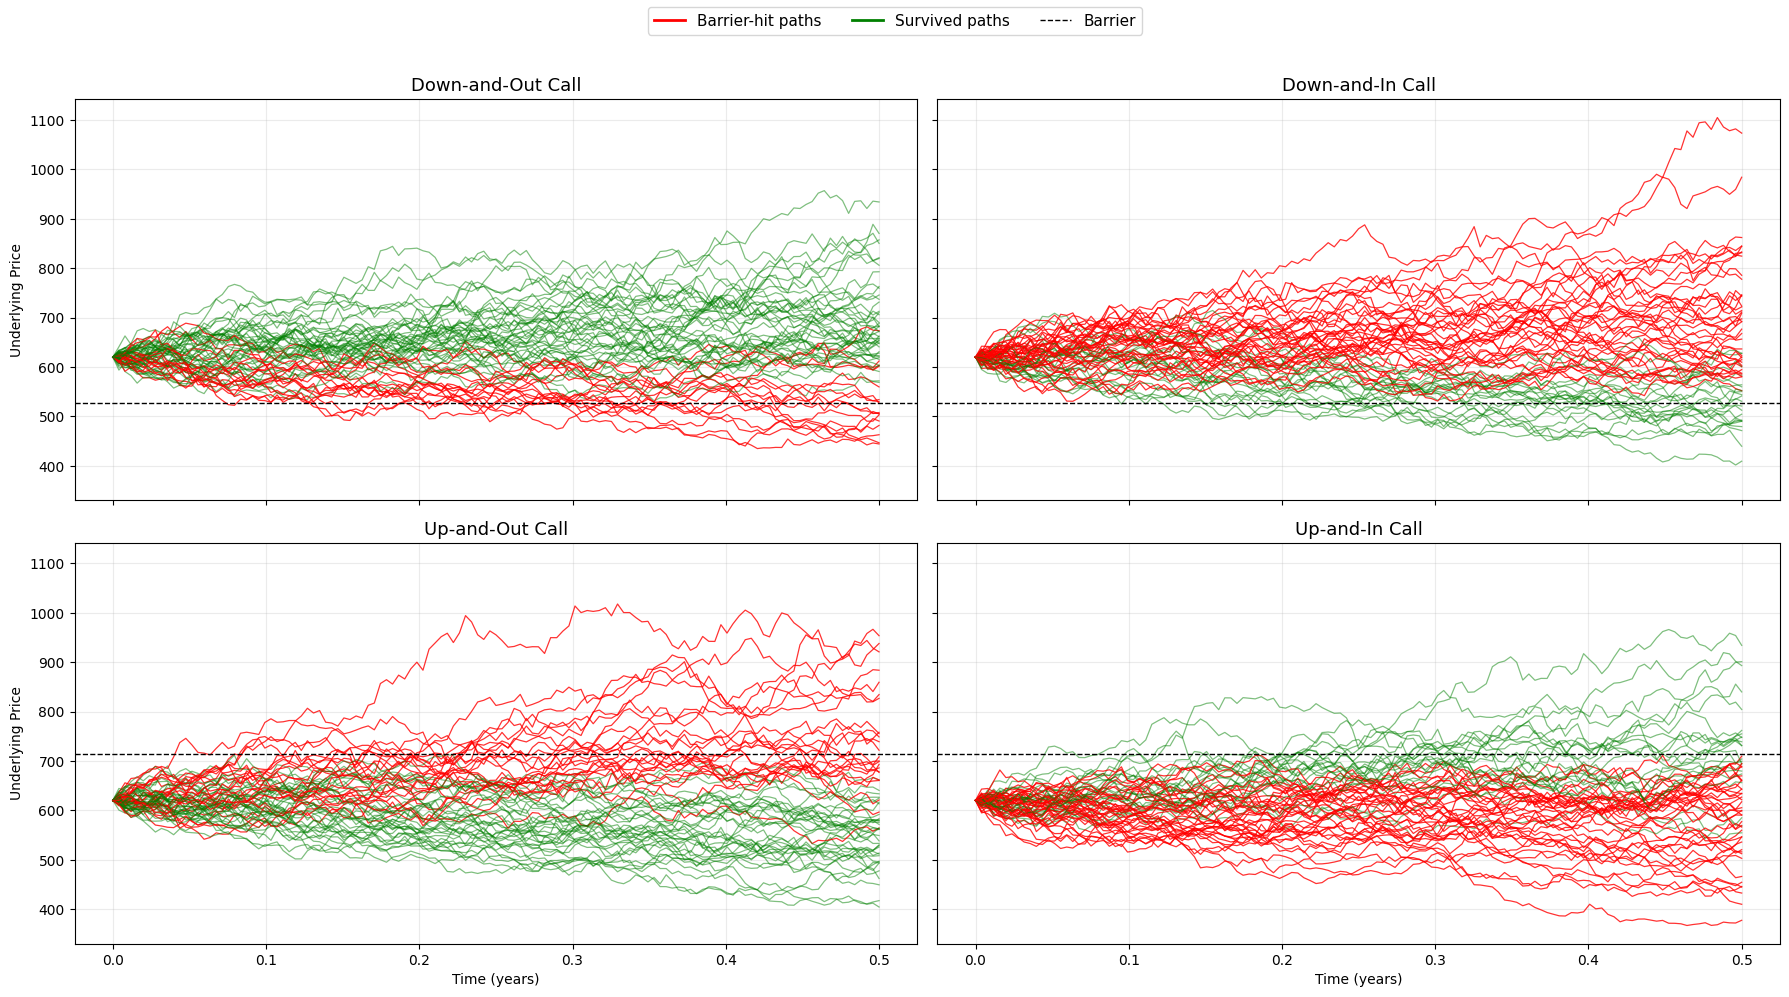

In [ ]:
n_plot = min(60, N)
rng = np.random.default_rng(123)
t = np.linspace(0, T, M + 1)

fig, axes = plt.subplots(2, 2, figsize=(18, 10), sharex=True, sharey=True)
axes = axes.flatten()

for ax, cfg in zip(axes, configs):

    if cfg["barrier_type"] == "down":
        B_plot = S0 * 0.85
    else:
        B_plot = S0 * 1.15

    price, payoff, ST, hit, S = barrier_option_mc(
        S0, K, B_plot, r, sigma, T, M, N, dt,
        option_type=cfg["option_type"],
        knock=cfg["knock"],
        barrier_type=cfg["barrier_type"]
    )

    idx = rng.choice(N, size=n_plot, replace=False)

    for i in idx:
        if cfg["knock"] == "out":
            if hit[i]:
                ax.plot(t, S[:, i], color="red", alpha=0.8, linewidth=0.9)
            else:
                ax.plot(t, S[:, i], color="green", alpha=0.5, linewidth=0.9)
        else:
            if hit[i]:
                ax.plot(t, S[:, i], color="green", alpha=0.5, linewidth=0.9)
            else:
                ax.plot(t, S[:, i], color="red", alpha=0.8, linewidth=0.9)

    ax.axhline(B_plot, color="black", linestyle="--", linewidth=1)
    ax.set_title(cfg["label"], fontsize=13)
    ax.grid(alpha=0.25)

axes[0].set_ylabel("Underlying Price")
axes[2].set_ylabel("Underlying Price")
axes[2].set_xlabel("Time (years)")
axes[3].set_xlabel("Time (years)")

legend_elems = [
    Line2D([0],[0], color="red", lw=2, label="Barrier-hit paths"),
    Line2D([0],[0], color="green", lw=2, label="Survived paths"),
    Line2D([0],[0], color="black", lw=1, linestyle="--", label="Barrier"),
]

fig.legend(handles=legend_elems, loc="upper center", ncol=3, fontsize=11)
plt.tight_layout(rect=[0, 0, 1, 0.94])
plt.show()

## Analysis of Monte Carlo Simulation

In [ ]:
n_paths_list = [1000, 5000, 10000, 50000, 100000]
n_runs = 10
records = []
df_results_dict = {}

for cfg in configs:

    records = []

    if cfg["barrier_type"] == "down":
        B_plot = S0 * 0.85
    else:
        B_plot = S0 * 1.15

    for n_paths in n_paths_list:
        prices = []
        knock_rates = []
        times = []

        for run in range(n_runs):
            start = time.time()

            price_run, payoff, ST, hit, S = barrier_option_mc(
                S0, K, B_plot, r, sigma, T, M, n_paths, dt,
                option_type=cfg["option_type"],
                knock=cfg["knock"],
                barrier_type=cfg["barrier_type"]
            )

            prices.append(price_run)
            knock_rates.append(hit.mean())
            times.append(time.time() - start)

        prices = np.array(prices)
        knock_rates = np.array(knock_rates)

        mean_price = prices.mean()
        std_price = prices.std(ddof=1)
        se_price = std_price / np.sqrt(n_runs)
        mean_knock = knock_rates.mean()

        records.append({
            "Number of Paths": n_paths,
            "Mean Price": mean_price,
            "Standard Error": se_price,
            "Knockout Rate": mean_knock
        })

    df_results_dict[cfg["label"]] = pd.DataFrame(records)

In [ ]:
df_results_dict["Down-and-Out Call"]
df_results_dict["Down-and-In Call"]
df_results_dict["Up-and-Out Call"]
df_results_dict["Up-and-In Call"]

,Number of Paths,Mean Price,Standard Error,Knockout Rate
0,1000,39.999327,0.664745,0.398800
1,5000,39.611354,0.222203,0.396480
2,10000,39.833650,0.136334,0.400330
3,50000,39.756857,0.074574,0.398146
4,100000,39.908549,0.098534,0.398620


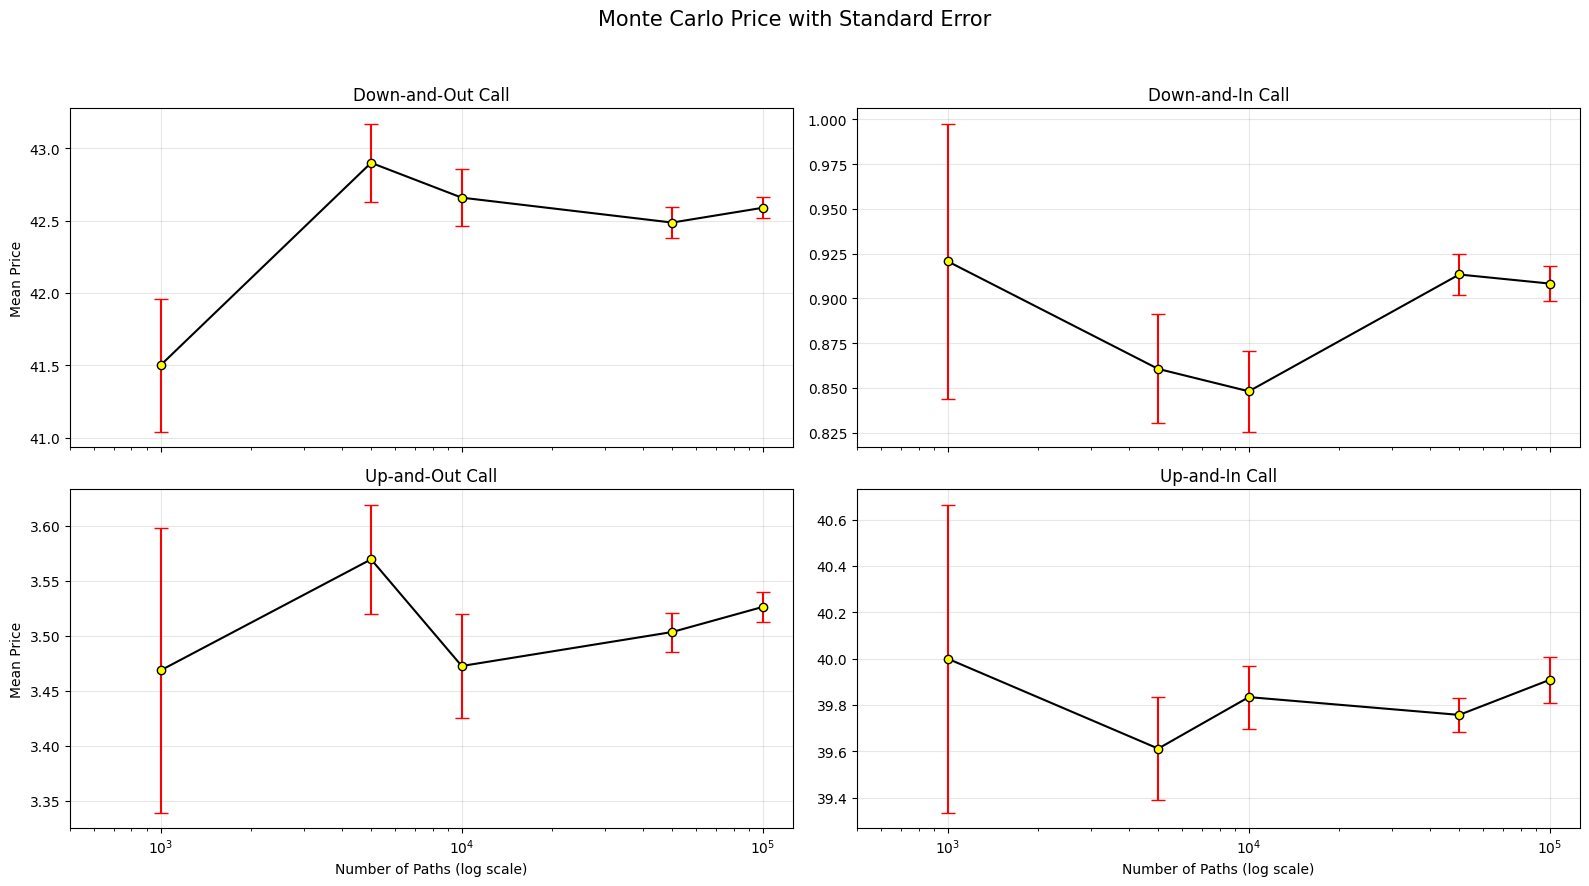

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(16, 9), sharex=True, sharey=False)
axes = axes.flatten()

dfs = [
    ("Down-and-Out Call", df_results_dict["Down-and-Out Call"]),
    ("Down-and-In Call",  df_results_dict["Down-and-In Call"]),
    ("Up-and-Out Call",   df_results_dict["Up-and-Out Call"]),
    ("Up-and-In Call",    df_results_dict["Up-and-In Call"]),
]

for ax, (title, df) in zip(axes, dfs):

    ax.errorbar(
        df["Number of Paths"],
        df["Mean Price"],
        yerr=df["Standard Error"],
        fmt="o-",
        capsize=5,
        color="black",
        ecolor="red",
        elinewidth=1.5,
        markerfacecolor="yellow",
        markeredgecolor="black",
        markersize=6
    )

    ax.set_xscale("log")
    ax.set_xlim(left=500)
    ax.set_title(title, fontsize=12)
    ax.grid(alpha=0.3)

axes[0].set_ylabel("Mean Price")
axes[2].set_ylabel("Mean Price")
axes[2].set_xlabel("Number of Paths (log scale)")
axes[3].set_xlabel("Number of Paths (log scale)")

plt.suptitle(
    "Monte Carlo Price with Standard Error",
    fontsize=15
)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


## Why Barrier Options
* Lower premiums than vanilla options as you are paying for less probability of a payout
* Useful for hedging conditional risks

## Risks
* Residual Monte Carlo error
* Barrier checked at discrete time steps
* Constant volatility assumption
* No jumps or stochastic volatility
